In [1]:
from pyspark.sql import SparkSession
import getpass
username = getpass.getuser()
spark = SparkSession. \
    builder. \
    config('spark.ui.port','0'). \
    config("spark.sql.warehouse.dir", f"/user/{username}/warehouse"). \
    config('spark.shuffle.useOldFetchProtocol','true'). \
    enableHiveSupport(). \
    master('yarn'). \
    getOrCreate()

In [2]:
spark

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import re
from itertools import combinations as cm
import matplotlib.dates as mdates
%matplotlib inline
from pyspark.sql.functions import *
import pyspark.sql.functions as F
pd.set_option('display.max_columns', None)

In [4]:
departments = spark.read \
.format("csv") \
.option("header",True) \
.option("inferschema",True) \
.load("/user/itv012839/inputdata/departments.csv");


In [5]:
departments.createOrReplaceTempView('departments')

In [6]:
employees = spark.read \
.format("csv") \
.option("header",True) \
.option("inferschema",True) \
.load("/user/itv012839/inputdata/emp_sql.csv")

In [7]:
employees = employees.withColumn('birth_date', to_date(col('birth_date'),'yyyy-MM-dd'))\
                .withColumn('hire_date', to_date(col('hire_date'),'yyyy-MM-dd'))\
                .withColumn('last_date', to_date(col('last_date'),'yyyy-MM-dd'))
employees.createOrReplaceTempView('employees')

In [8]:
dept_emp = spark.read \
 .format("csv") \
 .option("header",True) \
 .option("inferschema",True) \
 .load("/user/itv012839/inputdata/dept_emp.csv")

In [9]:
dept_emp.createOrReplaceTempView('dept_emp')

In [10]:
dept_manager = spark.read \
.format("csv") \
.option("header",True) \
.option("inferschema",True) \
.load("/user/itv012839/inputdata/dept_manager.csv")

In [11]:
dept_manager.createOrReplaceTempView('dept_manager')

In [12]:
salaries = spark.read \
.format("csv") \
.option("header",True) \
.option("inferschema",True) \
.load("/user/itv012839/inputdata/salaries.csv")

In [13]:
salaries.createOrReplaceTempView('salaries')

In [14]:
titles = spark.read \
.format("csv") \
.option("header",True) \
.option("inferschema",True) \
.load("/user/itv012839/inputdata/titles.csv")

In [15]:
titles.createOrReplaceTempView("titles")

__,validating data

In [16]:
titles.show()
titles.printSchema()
titles.count()

+--------+------------------+
|title_id|             title|
+--------+------------------+
|   s0001|             Staff|
|   s0002|      Senior Staff|
|   e0001|Assistant Engineer|
|   e0002|          Engineer|
|   e0003|   Senior Engineer|
|   e0004|  Technique Leader|
|   m0001|           Manager|
+--------+------------------+

root
 |-- title_id: string (nullable = true)
 |-- title: string (nullable = true)



7

In [17]:
employees.printSchema()
employees.count()

root
 |-- emp_no: integer (nullable = true)
 |-- emp_title_id: string (nullable = true)
 |-- birth_date: date (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- hire_date: date (nullable = true)
 |-- no_of_projects: integer (nullable = true)
 |-- last_performance_rating: string (nullable = true)
 |-- left2: integer (nullable = true)
 |-- last_date: date (nullable = true)



300024

In [18]:
employees.toPandas().head(20)

,emp_no,emp_title_id,birth_date,first_name,last_name,sex,hire_date,no_of_projects,last_performance_rating,left2,last_date
0,10001,e0003,None,Georgi,Facello,M,1986-06-26,9,C,1,1994-07-30
1,10002,s0001,None,Bezalel,Simmel,F,1985-11-21,8,B,0,None
2,10003,e0003,None,Parto,Bamford,M,1986-08-28,1,C,0,None
3,10004,e0003,None,Chirstian,Koblick,M,None,5,A,0,None
4,10005,s0001,1955-01-21,Kyoichi,Maliniak,M,None,6,A,0,None
5,10006,e0003,1953-04-20,Anneke,Preusig,F,None,10,B,0,None
6,10007,s0001,1957-05-23,Tzvetan,Zielinski,F,None,6,B,1,2002-09-18
7,10008,e0001,1958-02-19,Saniya,Kalloufi,M,1994-09-15,9,C,0,None
8,10009,e0003,1952-04-19,Sumant,Peac,F,1985-02-18,8,B,0,None
9,10010,e0002,None,Duangkaew,Piveteau,F,1989-08-24,4,A,0,None


In [19]:
dept_emp.show()
dept_emp.printSchema()
dept_emp.count()

+------+-------+
|emp_no|dept_no|
+------+-------+
| 10001|   d005|
| 10002|   d007|
| 10003|   d004|
| 10004|   d004|
| 10005|   d003|
| 10006|   d005|
| 10007|   d008|
| 10008|   d005|
| 10009|   d006|
| 10010|   d004|
| 10010|   d006|
| 10011|   d009|
| 10012|   d005|
| 10013|   d003|
| 10014|   d005|
| 10015|   d008|
| 10016|   d007|
| 10017|   d001|
| 10018|   d004|
| 10018|   d005|
+------+-------+
only showing top 20 rows

root
 |-- emp_no: integer (nullable = true)
 |-- dept_no: string (nullable = true)



331603

In [20]:
# dept_emp table was created by removing duplicate emp_no, to keep only the last the department for each employee

In [21]:
dept_emp.show()
dept_emp.printSchema()
dept_emp.count()

+------+-------+
|emp_no|dept_no|
+------+-------+
| 10001|   d005|
| 10002|   d007|
| 10003|   d004|
| 10004|   d004|
| 10005|   d003|
| 10006|   d005|
| 10007|   d008|
| 10008|   d005|
| 10009|   d006|
| 10010|   d004|
| 10010|   d006|
| 10011|   d009|
| 10012|   d005|
| 10013|   d003|
| 10014|   d005|
| 10015|   d008|
| 10016|   d007|
| 10017|   d001|
| 10018|   d004|
| 10018|   d005|
+------+-------+
only showing top 20 rows

root
 |-- emp_no: integer (nullable = true)
 |-- dept_no: string (nullable = true)



331603

In [22]:
dept_manager.show()
dept_manager.printSchema()
dept_manager.count()

+-------+------+
|dept_no|emp_no|
+-------+------+
|   d001|110022|
|   d001|110039|
|   d002|110085|
|   d002|110114|
|   d003|110183|
|   d003|110228|
|   d004|110303|
|   d004|110344|
|   d004|110386|
|   d004|110420|
|   d005|110511|
|   d005|110567|
|   d006|110725|
|   d006|110765|
|   d006|110800|
|   d006|110854|
|   d007|111035|
|   d007|111133|
|   d008|111400|
|   d008|111534|
+-------+------+
only showing top 20 rows

root
 |-- dept_no: string (nullable = true)
 |-- emp_no: integer (nullable = true)



24

In [23]:
salaries.show()
salaries.printSchema()
salaries.count()

+------+------+
|emp_no|salary|
+------+------+
| 10001| 60117|
| 10002| 65828|
| 10003| 40006|
| 10004| 40054|
| 10005| 78228|
| 10006| 40000|
| 10007| 56724|
| 10008| 46671|
| 10009| 60929|
| 10010| 72488|
| 10011| 42365|
| 10012| 40000|
| 10013| 40000|
| 10014| 46168|
| 10015| 40000|
| 10016| 70889|
| 10017| 71380|
| 10018| 55881|
| 10019| 44276|
| 10020| 40000|
+------+------+
only showing top 20 rows

root
 |-- emp_no: integer (nullable = true)
 |-- salary: integer (nullable = true)



300024

**Preparing Employees Table for EDA**

**Maximum date availiable in the Dataset**

In [24]:
maxDateInDataset = employees.select(greatest(max(col('last_date')),max(col('hire_date'))))
maxDateInDataset.show()

+----------------------------------------+
|greatest(max(last_date), max(hire_date))|
+----------------------------------------+
|                              2012-12-27|
+----------------------------------------+



In [25]:
maxDateInDataset = employees.select(greatest(max(col('last_date')),max(col('hire_date')))).toPandas().loc[0][0]
employees =  employees.withColumn('Age', maxDateInDataset.year-year(employees.birth_date))\
                .withColumn('Tenure_Years', F.when(col('left2')==1, year(employees.last_date)-year(employees.hire_date))\
                                                  .otherwise(maxDateInDataset.year-year(employees.hire_date)))
employees.createOrReplaceTempView('employees_at')
employees.toPandas().head(20)

,emp_no,emp_title_id,birth_date,first_name,last_name,sex,hire_date,no_of_projects,last_performance_rating,left2,last_date,Age,Tenure_Years
0,10001,e0003,None,Georgi,Facello,M,1986-06-26,9,C,1,1994-07-30,NaN,8.0
1,10002,s0001,None,Bezalel,Simmel,F,1985-11-21,8,B,0,None,NaN,27.0
2,10003,e0003,None,Parto,Bamford,M,1986-08-28,1,C,0,None,NaN,26.0
3,10004,e0003,None,Chirstian,Koblick,M,None,5,A,0,None,NaN,NaN
4,10005,s0001,1955-01-21,Kyoichi,Maliniak,M,None,6,A,0,None,57.0,NaN
5,10006,e0003,1953-04-20,Anneke,Preusig,F,None,10,B,0,None,59.0,NaN
6,10007,s0001,1957-05-23,Tzvetan,Zielinski,F,None,6,B,1,2002-09-18,55.0,NaN
7,10008,e0001,1958-02-19,Saniya,Kalloufi,M,1994-09-15,9,C,0,None,54.0,18.0
8,10009,e0003,1952-04-19,Sumant,Peac,F,1985-02-18,8,B,0,None,60.0,27.0
9,10010,e0002,None,Duangkaew,Piveteau,F,1989-08-24,4,A,0,None,NaN,23.0


**Exploratory Data Analysis

**1. A list showing employee number, last name, first name, sex, and salary for each employee

In [26]:
spark.sql("""
            SELECT e.emp_no, last_name, first_name, sex, salary 
            FROM employees e
            JOIN salaries s  ON e.emp_no = s.emp_no
         """).show()

+------+-----------+----------+---+------+
|emp_no|  last_name|first_name|sex|salary|
+------+-----------+----------+---+------+
| 10001|    Facello|    Georgi|  M| 60117|
| 10002|     Simmel|   Bezalel|  F| 65828|
| 10003|    Bamford|     Parto|  M| 40006|
| 10004|    Koblick| Chirstian|  M| 40054|
| 10005|   Maliniak|   Kyoichi|  M| 78228|
| 10006|    Preusig|    Anneke|  F| 40000|
| 10007|  Zielinski|   Tzvetan|  F| 56724|
| 10008|   Kalloufi|    Saniya|  M| 46671|
| 10009|       Peac|    Sumant|  F| 60929|
| 10010|   Piveteau| Duangkaew|  F| 72488|
| 10011|      Sluis|      Mary|  F| 42365|
| 10012|  Bridgland|  Patricio|  M| 40000|
| 10013|     Terkki| Eberhardt|  M| 40000|
| 10014|      Genin|     Berni|  M| 46168|
| 10015|  Nooteboom|  Guoxiang|  M| 40000|
| 10016|Cappelletti|  Kazuhito|  M| 70889|
| 10017|  Bouloucos| Cristinel|  F| 71380|
| 10018|       Peha|  Kazuhide|  F| 55881|
| 10019|    Haddadi|   Lillian|  M| 44276|
| 10020|    Warwick|    Mayuko|  M| 40000|
+------+---

In [27]:
employees.join(salaries, on='emp_no').select('emp_no','last_name','first_name','sex','salary').show()

+------+-----------+----------+---+------+
|emp_no|  last_name|first_name|sex|salary|
+------+-----------+----------+---+------+
| 10001|    Facello|    Georgi|  M| 60117|
| 10002|     Simmel|   Bezalel|  F| 65828|
| 10003|    Bamford|     Parto|  M| 40006|
| 10004|    Koblick| Chirstian|  M| 40054|
| 10005|   Maliniak|   Kyoichi|  M| 78228|
| 10006|    Preusig|    Anneke|  F| 40000|
| 10007|  Zielinski|   Tzvetan|  F| 56724|
| 10008|   Kalloufi|    Saniya|  M| 46671|
| 10009|       Peac|    Sumant|  F| 60929|
| 10010|   Piveteau| Duangkaew|  F| 72488|
| 10011|      Sluis|      Mary|  F| 42365|
| 10012|  Bridgland|  Patricio|  M| 40000|
| 10013|     Terkki| Eberhardt|  M| 40000|
| 10014|      Genin|     Berni|  M| 46168|
| 10015|  Nooteboom|  Guoxiang|  M| 40000|
| 10016|Cappelletti|  Kazuhito|  M| 70889|
| 10017|  Bouloucos| Cristinel|  F| 71380|
| 10018|       Peha|  Kazuhide|  F| 55881|
| 10019|    Haddadi|   Lillian|  M| 44276|
| 10020|    Warwick|    Mayuko|  M| 40000|
+------+---

**2. A list showing first name, last name, and hire date for employees who were hired in 1986.

In [28]:
spark.sql("""
            SELECT first_name, last_name, hire_date
            FROM employees
            WHERE year(hire_date) = 1986
         """).show()

+----------+-----------+----------+
|first_name|  last_name| hire_date|
+----------+-----------+----------+
|    Georgi|    Facello|1986-06-26|
|     Parto|    Bamford|1986-08-28|
|      Kwee|   Schusler|1986-02-26|
|   Kshitij|       Gils|1986-03-27|
|  Zhongwei|      Rosen|1986-10-30|
|    Kendra|    Hofting|1986-03-14|
|    Hilari|     Morton|1986-07-15|
|    Xuejia|     Ullian|1986-08-22|
|   Chikara|   Rissland|1986-01-23|
|  Domenick|   Peltason|1986-03-14|
|     Perry|  Shimshoni|1986-09-18|
|  Kazuhito|Encarnacion|1986-08-21|
|  Zhenbing|      Perng|1986-11-16|
|    Jaques|      Munro|1986-01-27|
|   Khedija| Mitsuhashi|1986-01-29|
|      Shaw|    Wendorf|1986-02-25|
| Shigehito|  Kropatsch|1986-03-28|
|      Arve| Fairtlough|1986-06-23|
|     Idoia|    Kavraki|1986-11-22|
|    Kellie|     Chinen|1986-06-19|
+----------+-----------+----------+
only showing top 20 rows



In [29]:
employees[year(col('hire_date'))==1986].select('first_name','last_name','hire_date').show()

+----------+-----------+----------+
|first_name|  last_name| hire_date|
+----------+-----------+----------+
|    Georgi|    Facello|1986-06-26|
|     Parto|    Bamford|1986-08-28|
|      Kwee|   Schusler|1986-02-26|
|   Kshitij|       Gils|1986-03-27|
|  Zhongwei|      Rosen|1986-10-30|
|    Kendra|    Hofting|1986-03-14|
|    Hilari|     Morton|1986-07-15|
|    Xuejia|     Ullian|1986-08-22|
|   Chikara|   Rissland|1986-01-23|
|  Domenick|   Peltason|1986-03-14|
|     Perry|  Shimshoni|1986-09-18|
|  Kazuhito|Encarnacion|1986-08-21|
|  Zhenbing|      Perng|1986-11-16|
|    Jaques|      Munro|1986-01-27|
|   Khedija| Mitsuhashi|1986-01-29|
|      Shaw|    Wendorf|1986-02-25|
| Shigehito|  Kropatsch|1986-03-28|
|      Arve| Fairtlough|1986-06-23|
|     Idoia|    Kavraki|1986-11-22|
|    Kellie|     Chinen|1986-06-19|
+----------+-----------+----------+
only showing top 20 rows



**3. A list showing the manager of each department with the following information: department number, department name, the manager's employee number, last name, first name.

In [30]:
spark.sql("""
            SELECT dm.dept_no, d.dept_name, e.emp_no, e.last_name, e.first_name, t.title
            FROM dept_manager dm 
            JOIN departments d ON dm.dept_no = d.dept_no
            JOIN employees e ON dm.emp_no = e.emp_no
            JOIN titles t ON e.emp_title_id = t.title_id AND t.title = 'Manager'
         """).show()

+-------+------------------+------+------------+-----------+-------+
|dept_no|         dept_name|emp_no|   last_name| first_name|  title|
+-------+------------------+------+------------+-----------+-------+
|   d001|         Marketing|110022|  Markovitch|  Margareta|Manager|
|   d001|         Marketing|110039|    Minakawa|   Vishwani|Manager|
|   d002|           Finance|110085|       Alpin|       Ebru|Manager|
|   d002|           Finance|110114|  Legleitner|      Isamu|Manager|
|   d003|   Human Resources|110183|Ossenbruggen|    Shirish|Manager|
|   d003|   Human Resources|110228|     Sigstam|    Karsten|Manager|
|   d004|        Production|110303|     Wegerle|  Krassimir|Manager|
|   d004|        Production|110344|       Cools|     Rosine|Manager|
|   d004|        Production|110386|      Kieras|       Shem|Manager|
|   d004|        Production|110420|    Ghazalie|      Oscar|Manager|
|   d005|       development|110511|    Hagimont|   DeForest|Manager|
|   d005|       development|110567

In [31]:
dept_manager.join(departments, on='dept_no')\
    .join(employees, on='emp_no')\
    .join(titles, employees.emp_title_id == titles.title_id)\
    .select('dept_no','dept_name','emp_no','last_name','first_name','title').show()

+-------+------------------+------+------------+-----------+-------+
|dept_no|         dept_name|emp_no|   last_name| first_name|  title|
+-------+------------------+------+------------+-----------+-------+
|   d001|         Marketing|110022|  Markovitch|  Margareta|Manager|
|   d001|         Marketing|110039|    Minakawa|   Vishwani|Manager|
|   d002|           Finance|110085|       Alpin|       Ebru|Manager|
|   d002|           Finance|110114|  Legleitner|      Isamu|Manager|
|   d003|   Human Resources|110183|Ossenbruggen|    Shirish|Manager|
|   d003|   Human Resources|110228|     Sigstam|    Karsten|Manager|
|   d004|        Production|110303|     Wegerle|  Krassimir|Manager|
|   d004|        Production|110344|       Cools|     Rosine|Manager|
|   d004|        Production|110386|      Kieras|       Shem|Manager|
|   d004|        Production|110420|    Ghazalie|      Oscar|Manager|
|   d005|       development|110511|    Hagimont|   DeForest|Manager|
|   d005|       development|110567

**4. A list showing the department of each employee with the following information: employee number, last name, first name, and department name.

In [32]:
spark.sql("""
            SELECT e.emp_no, last_name, first_name, d.dept_name 
            FROM employees e 
            JOIN dept_emp de ON e.emp_no = de.emp_no 
            JOIN departments d ON de.dept_no = d.dept_no
         """).show()

+------+-----------+----------+------------------+
|emp_no|  last_name|first_name|         dept_name|
+------+-----------+----------+------------------+
| 10001|    Facello|    Georgi|       development|
| 10002|     Simmel|   Bezalel|             Sales|
| 10003|    Bamford|     Parto|        Production|
| 10004|    Koblick| Chirstian|        Production|
| 10005|   Maliniak|   Kyoichi|   Human Resources|
| 10006|    Preusig|    Anneke|       development|
| 10007|  Zielinski|   Tzvetan|          Research|
| 10008|   Kalloufi|    Saniya|       development|
| 10009|       Peac|    Sumant|Quality Management|
| 10010|   Piveteau| Duangkaew|Quality Management|
| 10010|   Piveteau| Duangkaew|        Production|
| 10011|      Sluis|      Mary|  Customer Service|
| 10012|  Bridgland|  Patricio|       development|
| 10013|     Terkki| Eberhardt|   Human Resources|
| 10014|      Genin|     Berni|       development|
| 10015|  Nooteboom|  Guoxiang|          Research|
| 10016|Cappelletti|  Kazuhito|

In [33]:
employees.join(dept_emp, on='emp_no')\
    .join(departments, on='dept_no')\
    .select('emp_no','last_name','first_name','dept_name').show()

+------+-----------+----------+------------------+
|emp_no|  last_name|first_name|         dept_name|
+------+-----------+----------+------------------+
| 10001|    Facello|    Georgi|       development|
| 10002|     Simmel|   Bezalel|             Sales|
| 10003|    Bamford|     Parto|        Production|
| 10004|    Koblick| Chirstian|        Production|
| 10005|   Maliniak|   Kyoichi|   Human Resources|
| 10006|    Preusig|    Anneke|       development|
| 10007|  Zielinski|   Tzvetan|          Research|
| 10008|   Kalloufi|    Saniya|       development|
| 10009|       Peac|    Sumant|Quality Management|
| 10010|   Piveteau| Duangkaew|Quality Management|
| 10010|   Piveteau| Duangkaew|        Production|
| 10011|      Sluis|      Mary|  Customer Service|
| 10012|  Bridgland|  Patricio|       development|
| 10013|     Terkki| Eberhardt|   Human Resources|
| 10014|      Genin|     Berni|       development|
| 10015|  Nooteboom|  Guoxiang|          Research|
| 10016|Cappelletti|  Kazuhito|

5. A list showing first name, last name, and sex for employees whose first name is "Hercules" and last names begin with "B"

In [34]:
spark.sql("""
            SELECT first_name, last_name, sex 
            FROM employees 
            WHERE first_name = 'Hercules' AND last_name LIKE 'B%'
         """).show()

+----------+-------------+---+
|first_name|    last_name|sex|
+----------+-------------+---+
|  Hercules|   Benzmuller|  M|
|  Hercules|      Brendel|  F|
|  Hercules|   Baranowski|  M|
|  Hercules|     Barreiro|  M|
|  Hercules|         Baer|  M|
|  Hercules|Bernardinello|  F|
|  Hercules|      Basagni|  M|
|  Hercules|        Biran|  F|
|  Hercules|    Bernatsky|  M|
|  Hercules|         Bail|  F|
|  Hercules|        Birge|  F|
|  Hercules|      Bisiani|  F|
|  Hercules|       Bodoff|  M|
|  Hercules|        Biron|  F|
|  Hercules|      Buchter|  M|
|  Hercules|         Bain|  F|
|  Hercules|         Bahr|  M|
|  Hercules|         Baak|  M|
|  Hercules|     Benantar|  F|
|  Hercules|      Berstel|  F|
+----------+-------------+---+



In [35]:
employees[(col('first_name') == 'Hercules') & (col('last_name').like('B%'))]\
    .select('first_name','last_name','sex').show()

+----------+-------------+---+
|first_name|    last_name|sex|
+----------+-------------+---+
|  Hercules|   Benzmuller|  M|
|  Hercules|      Brendel|  F|
|  Hercules|   Baranowski|  M|
|  Hercules|     Barreiro|  M|
|  Hercules|         Baer|  M|
|  Hercules|Bernardinello|  F|
|  Hercules|      Basagni|  M|
|  Hercules|        Biran|  F|
|  Hercules|    Bernatsky|  M|
|  Hercules|         Bail|  F|
|  Hercules|        Birge|  F|
|  Hercules|      Bisiani|  F|
|  Hercules|       Bodoff|  M|
|  Hercules|        Biron|  F|
|  Hercules|      Buchter|  M|
|  Hercules|         Bain|  F|
|  Hercules|         Bahr|  M|
|  Hercules|         Baak|  M|
|  Hercules|     Benantar|  F|
|  Hercules|      Berstel|  F|
+----------+-------------+---+



6. A list showing all employees in the Sales department, including their employee number, last name, first name, and department name.

In [36]:
spark.sql("""
            SELECT e.emp_no, e.last_name, e.first_name, d.dept_name
            FROM employees e 
            JOIN dept_emp de ON e.emp_no = de.emp_no 
            JOIN departments d ON de.dept_no = d.dept_no AND d.dept_name = 'Sales'
         """).show()

+------+------------+----------+---------+
|emp_no|   last_name|first_name|dept_name|
+------+------------+----------+---------+
| 10002|      Simmel|   Bezalel|    Sales|
| 10016| Cappelletti|  Kazuhito|    Sales|
| 10034|        Swan|     Bader|    Sales|
| 10041|      Lenart|       Uri|    Sales|
| 10050|      Dredge|   Yinghua|    Sales|
| 10053|    Zschoche|    Sanjiv|    Sales|
| 10060| Billingsley|  Breannda|    Sales|
| 10061|      Herber|       Tse|    Sales|
| 10068|     Brattka|  Charlene|    Sales|
| 10087|     Eugenio|   Xinglin|    Sales|
| 10088|    Syrzycki|  Jungsoon|    Sales|
| 10089|Flasterstein| Sudharsan|    Sales|
| 10093|     Desikan|   Sailaja|    Sales|
| 10095|      Morton|    Hilari|    Sales|
| 10099|     Sullins|    Valter|    Sales|
| 10101|      Heyers|     Perla|    Sales|
| 10107|        Baca|      Dung|    Sales|
| 10125|     Hiltgen|     Syozo|    Sales|
| 10136|    Pintelas|    Zissis|    Sales|
| 10148|       Azumi|    Douadi|    Sales|
+------+---

In [37]:
employees.join(dept_emp, on='emp_no')\
    .join(departments[col('dept_name')=='Sales'], on='dept_no')\
    .select('emp_no','last_name','first_name','dept_name').show()

+------+------------+----------+---------+
|emp_no|   last_name|first_name|dept_name|
+------+------------+----------+---------+
| 10002|      Simmel|   Bezalel|    Sales|
| 10016| Cappelletti|  Kazuhito|    Sales|
| 10034|        Swan|     Bader|    Sales|
| 10041|      Lenart|       Uri|    Sales|
| 10050|      Dredge|   Yinghua|    Sales|
| 10053|    Zschoche|    Sanjiv|    Sales|
| 10060| Billingsley|  Breannda|    Sales|
| 10061|      Herber|       Tse|    Sales|
| 10068|     Brattka|  Charlene|    Sales|
| 10087|     Eugenio|   Xinglin|    Sales|
| 10088|    Syrzycki|  Jungsoon|    Sales|
| 10089|Flasterstein| Sudharsan|    Sales|
| 10093|     Desikan|   Sailaja|    Sales|
| 10095|      Morton|    Hilari|    Sales|
| 10099|     Sullins|    Valter|    Sales|
| 10101|      Heyers|     Perla|    Sales|
| 10107|        Baca|      Dung|    Sales|
| 10125|     Hiltgen|     Syozo|    Sales|
| 10136|    Pintelas|    Zissis|    Sales|
| 10148|       Azumi|    Douadi|    Sales|
+------+---

7. A list showing all employees in the Sales and Development departments, including their employee number, last name, first name, and department name.

In [38]:
spark.sql("""
            SELECT e.emp_no, e.last_name, e.first_name, d.dept_name
            FROM employees e 
            JOIN dept_emp de ON e.emp_no = de.emp_no 
            JOIN departments d ON de.dept_no = d.dept_no AND d.dept_name IN ('Sales','development')
         """).show()

+------+-----------+----------+-----------+
|emp_no|  last_name|first_name|  dept_name|
+------+-----------+----------+-----------+
| 10001|    Facello|    Georgi|development|
| 10002|     Simmel|   Bezalel|      Sales|
| 10006|    Preusig|    Anneke|development|
| 10008|   Kalloufi|    Saniya|development|
| 10012|  Bridgland|  Patricio|development|
| 10014|      Genin|     Berni|development|
| 10016|Cappelletti|  Kazuhito|      Sales|
| 10018|       Peha|  Kazuhide|development|
| 10021|       Erde|     Ramzi|development|
| 10022|     Famili|    Shahaf|development|
| 10023| Montemayor|     Bojan|development|
| 10025|     Heyers| Prasadram|development|
| 10027|    Reistad|    Divier|development|
| 10028|   Tempesti|  Domenick|development|
| 10031|     Joslin|   Karsten|development|
| 10034|       Swan|     Bader|      Sales|
| 10037|   Makrucki|   Pradeep|development|
| 10040|    Meriste|     Weiyi|development|
| 10041|     Lenart|       Uri|      Sales|
| 10043|    Tzvieli|    Yishay|d

In [39]:
employees.join(dept_emp, on='emp_no')\
    .join(departments[col('dept_name').isin('Sales','development')], on='dept_no')\
    .select('emp_no','last_name','first_name','dept_name').show()

+------+-----------+----------+-----------+
|emp_no|  last_name|first_name|  dept_name|
+------+-----------+----------+-----------+
| 10001|    Facello|    Georgi|development|
| 10002|     Simmel|   Bezalel|      Sales|
| 10006|    Preusig|    Anneke|development|
| 10008|   Kalloufi|    Saniya|development|
| 10012|  Bridgland|  Patricio|development|
| 10014|      Genin|     Berni|development|
| 10016|Cappelletti|  Kazuhito|      Sales|
| 10018|       Peha|  Kazuhide|development|
| 10021|       Erde|     Ramzi|development|
| 10022|     Famili|    Shahaf|development|
| 10023| Montemayor|     Bojan|development|
| 10025|     Heyers| Prasadram|development|
| 10027|    Reistad|    Divier|development|
| 10028|   Tempesti|  Domenick|development|
| 10031|     Joslin|   Karsten|development|
| 10034|       Swan|     Bader|      Sales|
| 10037|   Makrucki|   Pradeep|development|
| 10040|    Meriste|     Weiyi|development|
| 10041|     Lenart|       Uri|      Sales|
| 10043|    Tzvieli|    Yishay|d

8. A list showing the frequency count of employee last names, in descending order. ( i.e., how many employees share each last name

In [40]:
spark.sql("""
            SELECT last_name, count(*) AS Last_name_cnt
            FROM employees
            GROUP BY last_name
            ORDER BY Last_name_cnt DESC
         """).show()

+-----------+-------------+
|  last_name|Last_name_cnt|
+-----------+-------------+
|       Baba|          226|
|     Gelosh|          223|
|      Coorg|          223|
|    Sudbeck|          222|
|     Farris|          222|
|     Adachi|          221|
|     Osgood|          220|
|    Mandell|          218|
|     Masada|          218|
|     Neiman|          218|
|    Wendorf|          217|
|Boudaillier|          217|
|     Pettis|          216|
|    Solares|          216|
|     Mahnke|          216|
|   Cummings|          216|
|     Emmart|          215|
|   Collette|          215|
|   Birjandi|          215|
|    Kulisch|          215|
+-----------+-------------+
only showing top 20 rows



In [41]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count


employees.groupBy('last_name').agg(count('emp_no').alias('Last_name_cnt')) \
    .orderBy(col('Last_name_cnt').desc()).show()


+-----------+-------------+
|  last_name|Last_name_cnt|
+-----------+-------------+
|       Baba|          226|
|     Gelosh|          223|
|      Coorg|          223|
|    Sudbeck|          222|
|     Farris|          222|
|     Adachi|          221|
|     Osgood|          220|
|     Neiman|          218|
|    Mandell|          218|
|     Masada|          218|
|Boudaillier|          217|
|    Wendorf|          217|
|     Mahnke|          216|
|    Solares|          216|
|     Pettis|          216|
|   Cummings|          216|
|     Emmart|          215|
|    Kulisch|          215|
|   Birjandi|          215|
| Maksimenko|          215|
+-----------+-------------+
only showing top 20 rows



9. Histogram to show the salary distribution among the employees

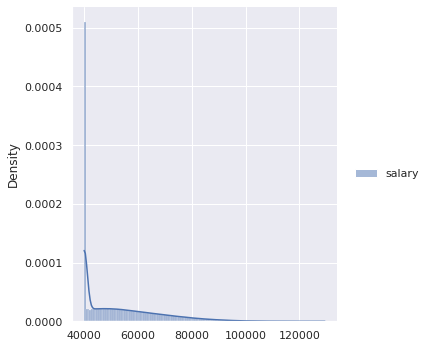

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setting the figure size
sns.set(rc={"figure.figsize": (10, 6)})

# Creating the displot
sns.displot(salaries.select('salary').toPandas(), kde=True, stat="density")  # kde=True adds a Kernel Density Estimate curve

plt.show()


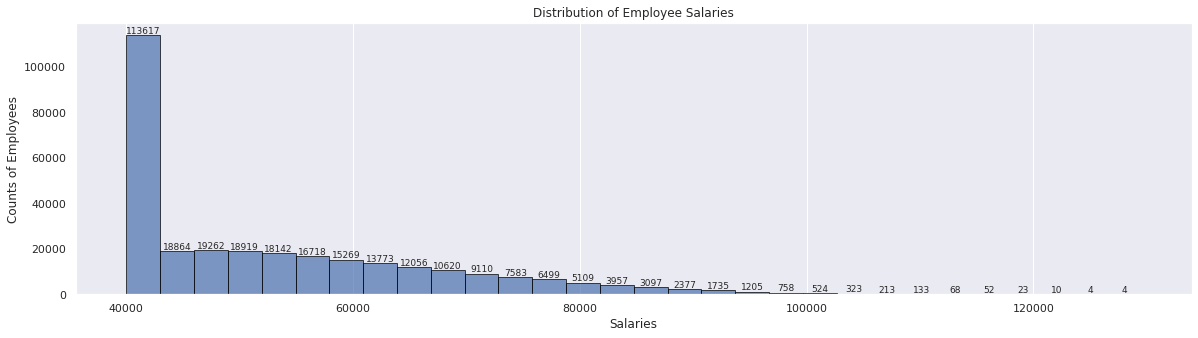

In [43]:
import matplotlib.pyplot as plt

# Convert the salary column to a pandas Series
salary_data = salaries.select('salary').toPandas().values.flatten()

# Create a histogram
plt.figure(figsize=(20, 5))  # Set the figure size
counts, bins, patches = plt.hist(salary_data, bins=30, edgecolor='black', alpha=0.7)  # Adjust number of bins as needed

# Add values on top of the bars with improved readability
for i in range(len(counts)):
    if counts[i] > 0:  # Only add labels to bars that have counts
        # Center the label on the bar and offset it slightly
        plt.text(bins[i] + (bins[1] - bins[0]) / 2, counts[i], int(counts[i]), 
                 ha='center', va='bottom', fontsize=9)

plt.xlabel('Salaries')
plt.ylabel('Counts of Employees')
plt.title('Distribution of Employee Salaries')  # Add a title
plt.grid(axis='y', alpha=0.75)  # Add gridlines for better readability
plt.show()


10. Bar graph to show the Average salary per title (designation)

In [44]:
q10 = spark.sql("""
            SELECT 
                t.title, 
                avg(Salary) Avg_Salary, 
                max(Salary) Max_Salary, 
                min(Salary) Min_Salary
            FROM salaries s
            JOIN employees e ON s.emp_no = e.emp_no
            JOIN titles t ON e.emp_title_id = t.title_id
            GROUP BY t.title
         """).toPandas()
q10.head(10)


,title,Avg_Salary,Max_Salary,Min_Salary
0,Staff,58465.382850,129492,40000
1,Assistant Engineer,48564.434447,99683,40000
2,Senior Staff,58550.172704,127238,40000
3,Senior Engineer,48506.799871,110449,40000
4,Engineer,48535.336511,100683,40000
5,Manager,51531.041667,72446,40000
6,Technique Leader,48582.896092,104065,40000


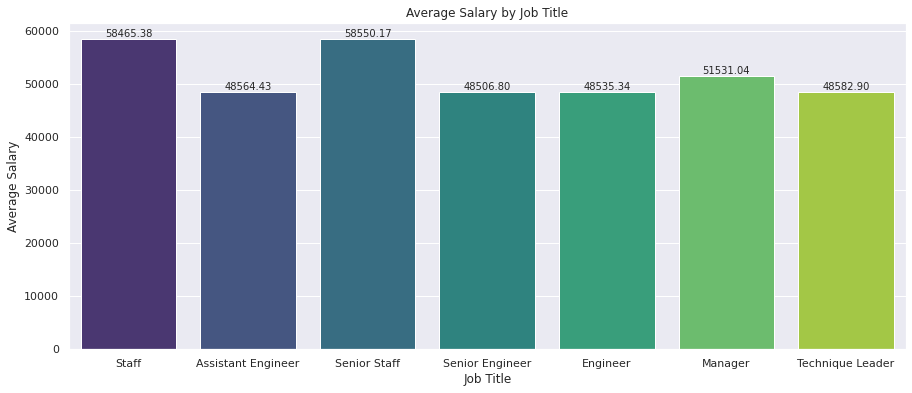

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={"figure.figsize": (15, 6)})
ax = sns.barplot(data=q10, x='title', y='Avg_Salary', palette='viridis')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)
plt.xlabel('Job Title') 
plt.ylabel('Average Salary') 
plt.title('Average Salary by Job Title') 
plt.show()


11. Calculate employee tenure & show the tenure distribution among the employees

In [46]:
q11 = spark.sql("""
           SELECT 
                CASE WHEN last_date IS NULL 
                     THEN (SELECT year(greatest(max(last_date), max(hire_date))) FROM employees)-year(hire_date)
                ELSE year(last_date)-year(hire_date) END AS Tenure_Years, 
                count(*) AS Tenure_cnt
            FROM employees
            GROUP BY Tenure_Years
            ORDER BY Tenure_cnt DESC
         """).toPandas()
q11.head()


,Tenure_Years,Tenure_cnt
0,NaN,118418
1,26.0,20432
2,27.0,20205
3,25.0,19126
4,24.0,17901


In [47]:
employees.groupBy('Tenure_Years').agg(count('emp_no').alias('Tenure_cnt'))\
    .orderBy(col('Tenure_cnt').desc()).toPandas().head()

,Tenure_Years,Tenure_cnt
0,NaN,125591
1,26.0,19576
2,27.0,19370
3,25.0,18326
4,24.0,17115


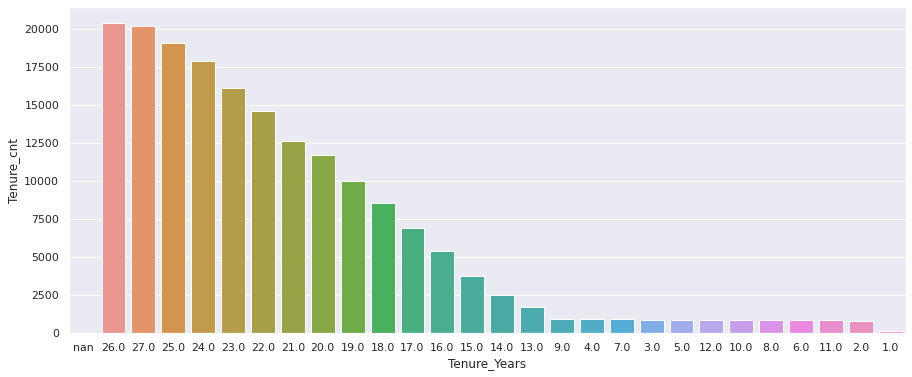

In [48]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.barplot(data=q11, x='Tenure_Years', y='Tenure_cnt',\
           order=q11.sort_values('Tenure_cnt',ascending = False).Tenure_Years)
plt.show()

12. Count of Employee Status (Currently working or Left) in different departments grouped by gender

In [49]:
spark.sql("""
            SELECT
                dept_name, sex,
                count(Left2) Total_Count,
                sum(CASE WHEN Left2 = 0 THEN 1 ELSE 0 END) Working_Count,
                sum(Left2) Left_Count
            FROM Employees e
            JOIN dept_emp de ON e.emp_no = de.emp_no
            JOIN departments d ON de.dept_no = d.dept_no
            GROUP BY dept_name, sex
         """).show()

+------------------+---+-----------+-------------+----------+
|         dept_name|sex|Total_Count|Working_Count|Left_Count|
+------------------+---+-----------+-------------+----------+
|Quality Management|  M|      12039|        10839|      1200|
|           Finance|  F|       7015|         6345|       670|
|   Human Resources|  M|      10711|         9635|      1076|
|Quality Management|  F|       8078|         7260|       818|
|   Human Resources|  F|       7075|         6354|       721|
|             Sales|  M|      31391|        28180|      3211|
|  Customer Service|  M|      14132|        12713|      1419|
|       development|  M|      51449|        46295|      5154|
|         Marketing|  F|       8037|         7282|       755|
|          Research|  F|       8439|         7601|       838|
|        Production|  F|      29549|        26520|      3029|
|          Research|  M|      12687|        11427|      1260|
|           Finance|  M|      10331|         9354|       977|
|       

13. Max, Min and Avg age of Employees in diffrent departments

In [50]:
spark.sql("""
           SELECT dept_name, min(Age), max(Age), avg(Age)
           FROM (
            SELECT
                dept_name, e.emp_no,
                    (SELECT year(greatest(max(last_date), max(hire_date))) FROM Employees)-year(birth_date) Age
            FROM employees e
            JOIN dept_emp de ON e.emp_no = de.emp_no
            JOIN departments d ON de.dept_no = d.dept_no 
            )a
          GROUP BY dept_name
         """).show()

+------------------+--------+--------+------------------+
|         dept_name|min(Age)|max(Age)|          avg(Age)|
+------------------+--------+--------+------------------+
|             Sales|      47|      60| 53.90621332741286|
|Quality Management|      47|      60| 53.94434381689445|
|           Finance|      47|      60|53.937594553706504|
|        Production|      47|      60| 53.93944493056023|
|          Research|      47|      60| 53.87746511809182|
|  Customer Service|      47|      60| 53.93894883397146|
|         Marketing|      47|      60|53.894827303977735|
|       development|      47|      60| 53.89016758694178|
|   Human Resources|      47|      60| 53.94171032934132|
+------------------+--------+--------+------------------+



The Age group distribution is very uniform accross all the departments.

14. Count of Employees in various titles

In [51]:
q14 = spark.sql("""
            SELECT 
                t.title, 
                count(Salary) Emp_Count
            FROM salaries s
            JOIN employees e ON s.emp_no = e.emp_no
            JOIN titles t ON e.emp_title_id = t.title_id
            GROUP BY t.title
            ORDER BY Emp_Count DESC
         """).toPandas()
q14.head(10)

,title,Emp_Count
0,Staff,107384
1,Senior Engineer,97747
2,Engineer,47303
3,Senior Staff,26583
4,Technique Leader,15148
5,Assistant Engineer,5835
6,Manager,24


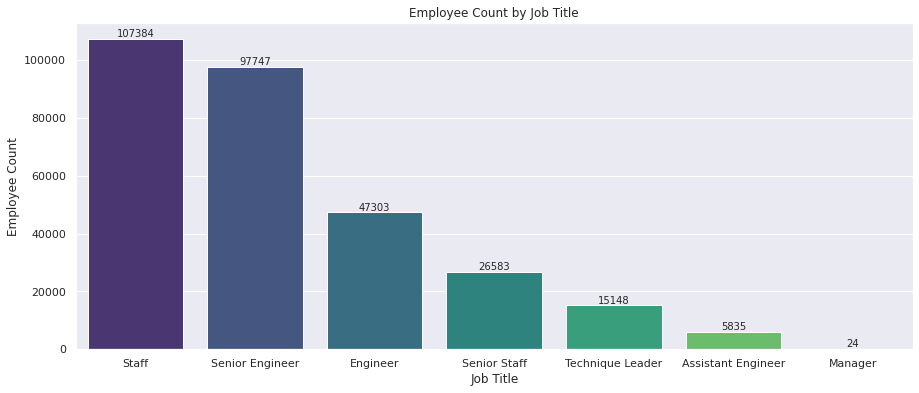

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={"figure.figsize": (15, 6)})
ax = sns.barplot(data=q14, x='title', y='Emp_Count', palette='viridis')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # Display integer value for employee count
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the label at the center of the bar
                ha='center', va='bottom', fontsize=10)  # Center the text horizontally

plt.xlabel('Job Title')  # Set the x-axis label
plt.ylabel('Employee Count')  # Set the y-axis label
plt.title('Employee Count by Job Title')  # Set the title
plt.show()


15 Average Tenure Distribution accross Departments

In [53]:
q15 = spark.sql("""
            SELECT 
                dept_name, 
                avg(Tenure_Years) Tenure
            FROM employees_at e
            JOIN dept_emp de ON e.emp_no = de.emp_no
            JOIN departments d ON de.dept_no = d.dept_no
            GROUP BY dept_name
            ORDER BY Tenure DESC
         """).toPandas()
q15.head(10)

,dept_name,Tenure
0,Research,21.560039
1,Finance,21.551176
2,development,21.496745
3,Marketing,21.472833
4,Production,21.469624
5,Sales,21.465932
6,Customer Service,21.461488
7,Quality Management,21.436041
8,Human Resources,21.421436


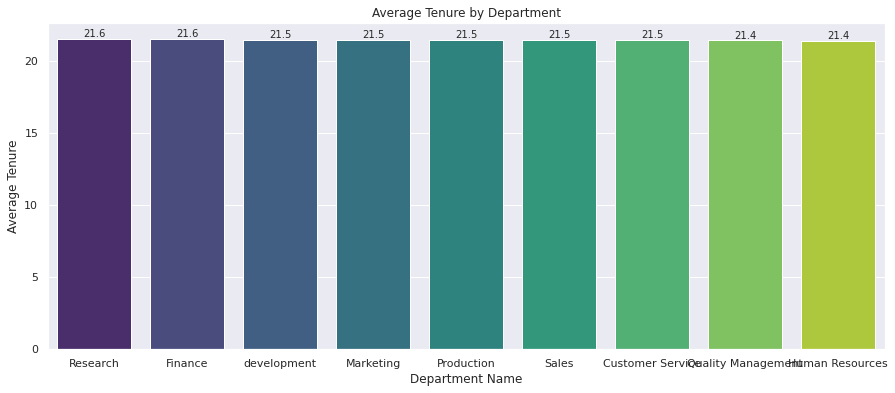

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={"figure.figsize": (15, 6)})
ax = sns.barplot(data=q15, x='dept_name', y='Tenure', palette='viridis')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}',  # Display the tenure value with one decimal place
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the label at the center of the bar
                ha='center', va='bottom', fontsize=10)  # Center the text horizontally

plt.xlabel('Department Name')  # Set the x-axis label
plt.ylabel('Average Tenure')  # Set the y-axis label
plt.title('Average Tenure by Department')  # Set the title
plt.show()


16 Average Tenure Distribution accross Titles

In [55]:
q16 = spark.sql("""
            SELECT 
                title, 
                avg(Tenure_Years) Tenure
            FROM employees_at e
            JOIN titles t ON e.emp_title_id = t.title_id
            GROUP BY title
            ORDER BY Tenure DESC
         """).toPandas()
q16.head(10)

,title,Tenure
0,Manager,24.666667
1,Senior Engineer,22.164179
2,Staff,21.491414
3,Technique Leader,21.487824
4,Senior Staff,21.467809
5,Engineer,20.235239
6,Assistant Engineer,19.998835


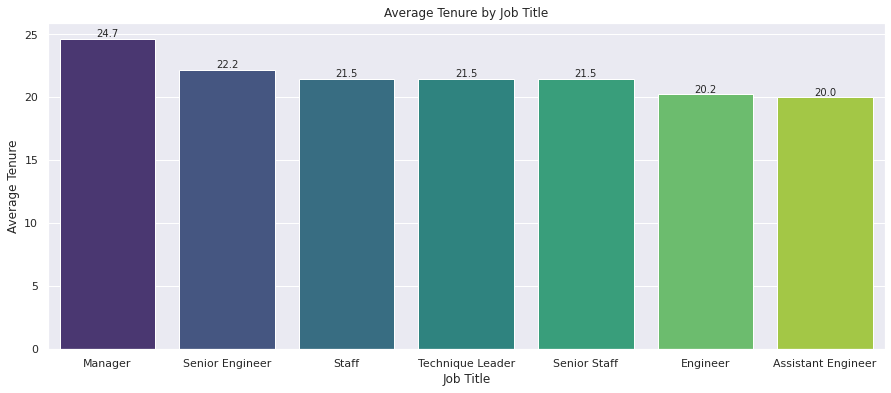

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={"figure.figsize": (15, 6)})

ax = sns.barplot(data=q16, x='title', y='Tenure', palette='viridis')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}',  # Display the tenure value with one decimal place
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the label at the center of the bar
                ha='center', va='bottom', fontsize=10)  # Center the text horizontally

plt.xlabel('Job Title')  # Set the x-axis label
plt.ylabel('Average Tenure')  # Set the y-axis label
plt.title('Average Tenure by Job Title')  # Set the title
plt.show()


Building Spark ML Model and Pipeline

Creating Final Dataframe

In [57]:
# Joining employees, salaries, departments, titles
emp_tsd = employees.join(titles, employees.emp_title_id == titles.title_id)\
    .join(salaries, on='emp_no')\
    .join(dept_emp, on='emp_no')\
    .join(departments, on='dept_no')\
    .withColumnRenamed('left2', 'left')
emp_tsd.toPandas().head(10)

,dept_no,emp_no,emp_title_id,birth_date,first_name,last_name,sex,hire_date,no_of_projects,last_performance_rating,left,last_date,Age,Tenure_Years,title_id,title,salary,dept_name
0,d005,10001,e0003,None,Georgi,Facello,M,1986-06-26,9,C,1,1994-07-30,NaN,8.0,e0003,Senior Engineer,60117,development
1,d007,10002,s0001,None,Bezalel,Simmel,F,1985-11-21,8,B,0,None,NaN,27.0,s0001,Staff,65828,Sales
2,d004,10003,e0003,None,Parto,Bamford,M,1986-08-28,1,C,0,None,NaN,26.0,e0003,Senior Engineer,40006,Production
3,d004,10004,e0003,None,Chirstian,Koblick,M,None,5,A,0,None,NaN,NaN,e0003,Senior Engineer,40054,Production
4,d003,10005,s0001,1955-01-21,Kyoichi,Maliniak,M,None,6,A,0,None,57.0,NaN,s0001,Staff,78228,Human Resources
5,d005,10006,e0003,1953-04-20,Anneke,Preusig,F,None,10,B,0,None,59.0,NaN,e0003,Senior Engineer,40000,development
6,d008,10007,s0001,1957-05-23,Tzvetan,Zielinski,F,None,6,B,1,2002-09-18,55.0,NaN,s0001,Staff,56724,Research
7,d005,10008,e0001,1958-02-19,Saniya,Kalloufi,M,1994-09-15,9,C,0,None,54.0,18.0,e0001,Assistant Engineer,46671,development
8,d006,10009,e0003,1952-04-19,Sumant,Peac,F,1985-02-18,8,B,0,None,60.0,27.0,e0003,Senior Engineer,60929,Quality Management
9,d006,10010,e0002,None,Duangkaew,Piveteau,F,1989-08-24,4,A,0,None,NaN,23.0,e0002,Engineer,72488,Quality Management


In [58]:
dfp = emp_tsd.toPandas()
dfp.dtypes

dept_no                     object
emp_no                       int32
emp_title_id                object
birth_date                  object
first_name                  object
last_name                   object
sex                         object
hire_date                   object
no_of_projects               int32
last_performance_rating     object
left                         int32
last_date                   object
Age                        float64
Tenure_Years               float64
title_id                    object
title                       object
salary                       int32
dept_name                   object
dtype: object

Continous Variables

In [59]:
conti_var_df = dfp.loc[:, (dfp.dtypes == 'float64') | (dfp.dtypes == 'int64') | (dfp.dtypes == 'int32')]
cat_var_df = dfp.loc[:, (dfp.dtypes == 'object')]

In [60]:
def fun_describe(x):

    # Records and missing values
    n_tot = x.shape[0]
    n_count = x.count()
    n_miss = x.isna().sum()
    n_miss_perc = n_miss / n_tot

    # IQR
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q3 + 1.5 * iqr

    return pd.Series(data=[
        x.dtypes, n_tot, n_count, n_miss, n_miss_perc,
        x.nunique(),
        x.sum(),
        x.mean(),
        x.std(),
        x.var(), iqr, lc_iqr, uc_iqr,
        x.min(),
        x.max(),
        x.quantile(0.01),
        x.quantile(0.05),
        x.quantile(0.1),
        x.quantile(0.25),
        x.quantile(0.5),
        x.quantile(0.75),
        x.quantile(0.90),
        x.quantile(0.95),
        x.quantile(0.99)
    ],
        index=[
        'dtype', 'tot', 'n', 'nmiss', 'miss_perc',
        'cardinality', 'sum', 'mean', 'std', 'var', 'iqr',
        'lc_iqr', 'uc_iqr', 'min', 'max', 'p1', 'p5', 'p10',
        'p25', 'p50', 'p75', 'p90', 'p95', 'p99'
    ])
conti_var_df.apply(fun_describe).T


,dtype,tot,n,nmiss,miss_perc,cardinality,sum,mean,std,var,iqr,lc_iqr,uc_iqr,min,max,p1,p5,p10,p25,p50,p75,p90,p95,p99
emp_no,int32,331603,331603,0,0,300024,84005851824,253333,161832,2.61896e+10,339994,-424986,934990,10001,499999,13002,24998.1,39997.2,85005.5,250001,425000,469997,484996,496999
no_of_projects,int32,331603,331603,0,0,10,1825427,5.50486,2.87283,8.25314,5,-4.5,15.5,1,10,1,1,2,3,6,8,10,10,10
left,int32,331603,331603,0,0,2,33021,0.0995799,0.29944,0.089664,0,0,0,0,1,0,0,0,0,0,0,0,1,1
Age,float64,331603,200537,131066,0.39525,14,1.0812e+07,53.9151,3.74961,14.0596,6,42,66,47,60,48,48,49,51,54,57,59,60,60
Tenure_Years,float64,331603,192714,138889,0.418841,27,4.1397e+06,21.4811,5.06033,25.6069,6,10,34,1,27,3,11,15,19,23,25,27,27,27
salary,int32,331603,331603,0,0,50355,17565748870,52972.2,14299,2.04461e+08,21765,7352.5,94412.5,40000,129492,40000,40000,40000,40000,48691,61765,74160.8,81445,94357.9


Here, 'emp_no' is having numeric datatype but not a variable to be considered as it has maximum cardinality i.e. primary key, used for identification only.

In [61]:
def fun_obj_describe(x):

    # Records and missing values
    n_tot = x.shape[0]
    n_count = x.count()
    n_miss = x.isna().sum()
    n_miss_perc = n_miss / n_tot

    return pd.Series(data=[
        x.dtypes, n_tot, n_count, n_miss, n_miss_perc,
        x.nunique()
    ],
        index=[
        'dtype', 'tot', 'n', 'nmiss', 'miss_perc',
        'cardinality'
    ])

cat_var_df.apply(fun_obj_describe).T

,dtype,tot,n,nmiss,miss_perc,cardinality
dept_no,object,331603,331603,0,0,9
emp_title_id,object,331603,331603,0,0,7
birth_date,object,331603,200537,131066,0.39525,2877
first_name,object,331603,331603,0,0,1276
last_name,object,331603,331603,0,0,1638
sex,object,331603,331603,0,0,2
hire_date,object,331603,200647,130956,0.394918,3290
last_performance_rating,object,331603,331603,0,0,5
last_date,object,331603,19959,311644,0.939811,4591
title_id,object,331603,331603,0,0,7


Encoding columns with high cardinality may effect the model, so all of these categorical cols with high cardinality will be dropped later.

**Checking Dependencies

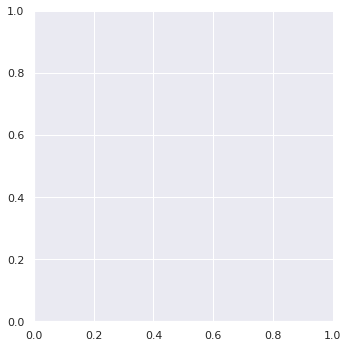

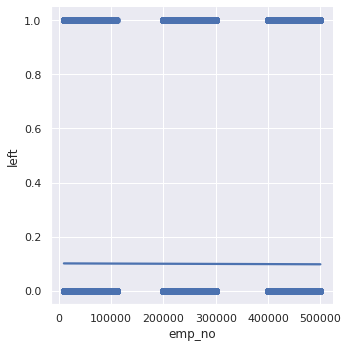

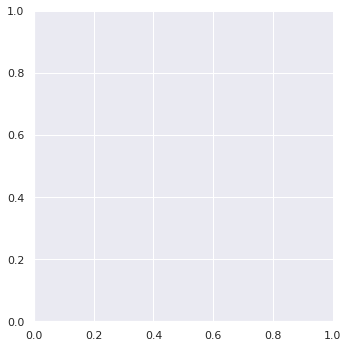

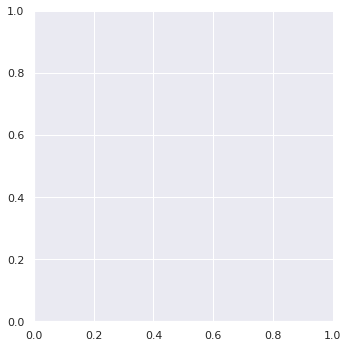

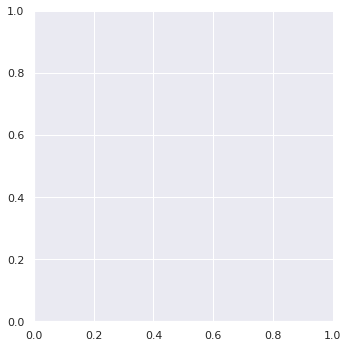

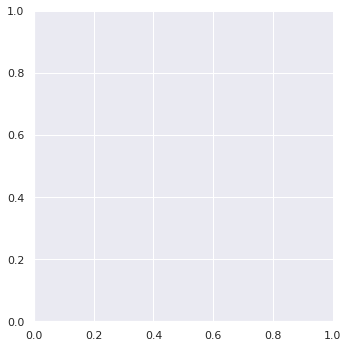

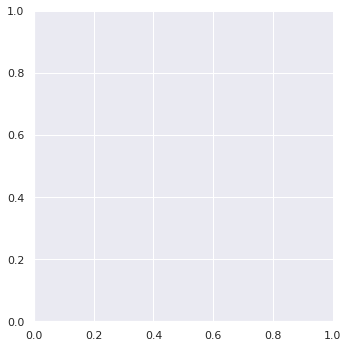

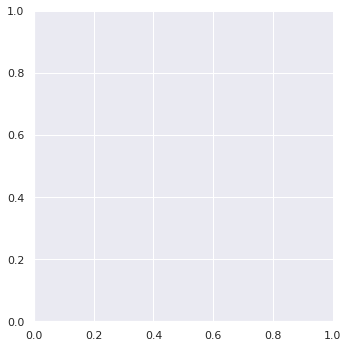

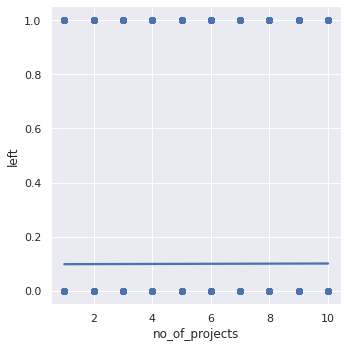

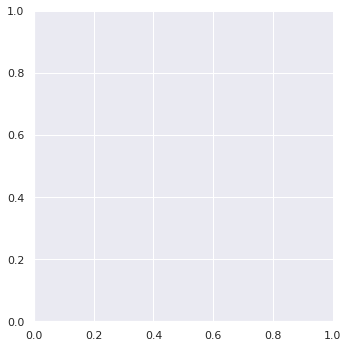

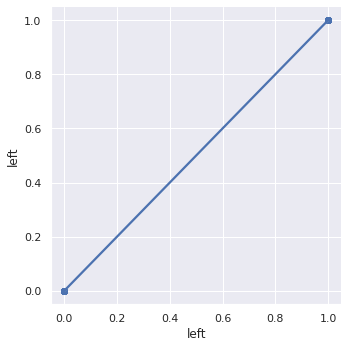

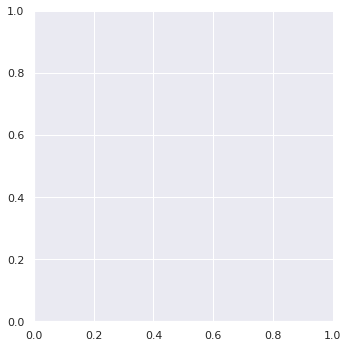

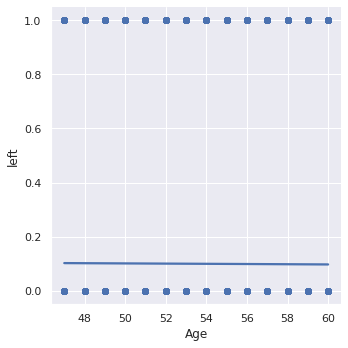

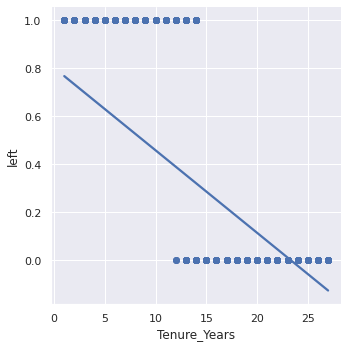

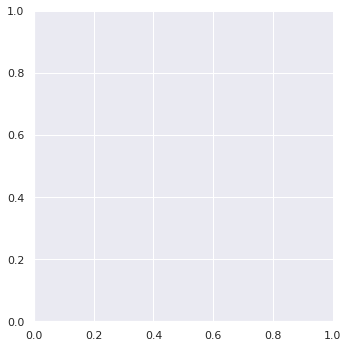

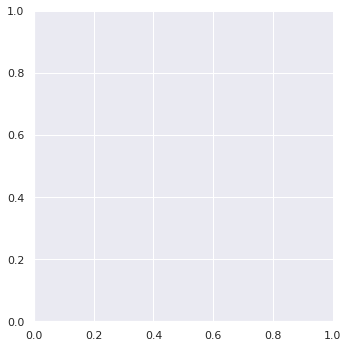

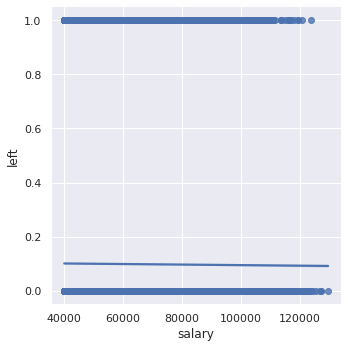

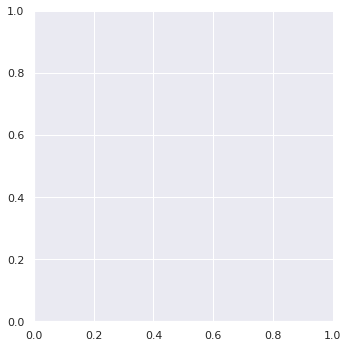

In [62]:
for col in emp_tsd.toPandas().columns:
  try:
    sns.lmplot(x= col, y='left', data=emp_tsd.toPandas())
    plt.show()
  except:
    pass


Dropping these following columns since these do not seem to have any effect in Employee Left Status : 'emp_title_id','birth_date','last_date','hire_date','emp_no','title_id','dept_no','first_name','last_name'

In [63]:
df = emp_tsd.drop('emp_title_id','birth_date','last_date','hire_date'\
                  ,'emp_no','title_id','dept_no','first_name','last_name')
df.toPandas().head(20)

,sex,no_of_projects,last_performance_rating,left,Age,Tenure_Years,title,salary,dept_name
0,M,9,C,1,NaN,8.0,Senior Engineer,60117,development
1,F,8,B,0,NaN,27.0,Staff,65828,Sales
2,M,1,C,0,NaN,26.0,Senior Engineer,40006,Production
3,M,5,A,0,NaN,NaN,Senior Engineer,40054,Production
4,M,6,A,0,57.0,NaN,Staff,78228,Human Resources
5,F,10,B,0,59.0,NaN,Senior Engineer,40000,development
6,F,6,B,1,55.0,NaN,Staff,56724,Research
7,M,9,C,0,54.0,18.0,Assistant Engineer,46671,development
8,F,8,B,0,60.0,27.0,Senior Engineer,60929,Quality Management
9,F,4,A,0,NaN,23.0,Engineer,72488,Quality Management


In [64]:
df.printSchema()

root
 |-- sex: string (nullable = true)
 |-- no_of_projects: integer (nullable = true)
 |-- last_performance_rating: string (nullable = true)
 |-- left: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure_Years: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- salary: integer (nullable = true)
 |-- dept_name: string (nullable = true)



**Data Preparation for Modeling

Label Encoding :

last_performance_rating :

In [65]:
df.select('last_performance_rating').distinct().show()

+-----------------------+
|last_performance_rating|
+-----------------------+
|                      B|
|                      C|
|                      A|
|                      S|
|                    PIP|
+-----------------------+



Considering the the order as S > A > B > C > PIP, Encoding values as S = 5, A = 4, B = 3, C = 2, PIP = 1

In [66]:
df = df.withColumn('last_performance_rating', F.when(df.last_performance_rating=='S',5)\
                                               .when(df.last_performance_rating=='A',4)\
                                               .when(df.last_performance_rating=='B',3)\
                                               .when(df.last_performance_rating=='C',2)\
                                               .otherwise(1))

title :

In [67]:
df.select('title').distinct().show()

+------------------+
|             title|
+------------------+
|             Staff|
|Assistant Engineer|
|      Senior Staff|
|   Senior Engineer|
|          Engineer|
|           Manager|
|  Technique Leader|
+------------------+



Considering the the order as Staff < Senior Staff < Assistant Engineer < Engineer < Senior Engineer < Technique Leader < Manager, Encoding values as Manager = 7, Technique Leader = 6, Senior Engineer = 5, Engineer = 4, Assistant Engineer = 3, Senior Staff = 2, Staff = 1

In [68]:
df = df.withColumn('title', F.when(df.title=='Manager',7)\
                             .when(df.title=='Technique Leader',6)\
                             .when(df.title=='Senior Engineer',5)\
                             .when(df.title=='Engineer',4)\
                             .when(df.title=='Assistant Engineer',3)\
                             .when(df.title=='Senior Staff',2)\
                             .otherwise(1))

In [69]:
df.show()

+---+--------------+-----------------------+----+----+------------+-----+------+------------------+
|sex|no_of_projects|last_performance_rating|left| Age|Tenure_Years|title|salary|         dept_name|
+---+--------------+-----------------------+----+----+------------+-----+------+------------------+
|  M|             9|                      2|   1|null|           8|    5| 60117|       development|
|  F|             8|                      3|   0|null|          27|    1| 65828|             Sales|
|  M|             1|                      2|   0|null|          26|    5| 40006|        Production|
|  M|             5|                      4|   0|null|        null|    5| 40054|        Production|
|  M|             6|                      4|   0|  57|        null|    1| 78228|   Human Resources|
|  F|            10|                      3|   0|  59|        null|    5| 40000|       development|
|  F|             6|                      3|   1|  55|        null|    1| 56724|          Research|


In [70]:
# Back_Up df after Label Encoding
df_bkup = df

One-Hot-Encoding :

In [71]:
#Encoding all categorical features
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder

In [72]:
# create object of StringIndexer class and specify input and output column
SI_sex = StringIndexer(inputCol='sex',outputCol='sex_Index')
SI_dept_name = StringIndexer(inputCol='dept_name',outputCol='dept_name_Index')

# transform the data
df = SI_sex.fit(df).transform(df)
df = SI_dept_name.fit(df).transform(df)

# view the transformed data
df.select('sex', 'sex_Index', 'dept_name', 'dept_name_Index').show(10)

+---+---------+------------------+---------------+
|sex|sex_Index|         dept_name|dept_name_Index|
+---+---------+------------------+---------------+
|  M|      0.0|       development|            0.0|
|  F|      1.0|             Sales|            2.0|
|  M|      0.0|        Production|            1.0|
|  M|      0.0|        Production|            1.0|
|  M|      0.0|   Human Resources|            7.0|
|  F|      1.0|       development|            0.0|
|  F|      1.0|          Research|            4.0|
|  M|      0.0|       development|            0.0|
|  F|      1.0|Quality Management|            6.0|
|  F|      1.0|Quality Management|            6.0|
+---+---------+------------------+---------------+
only showing top 10 rows



In [73]:
# create object and specify input and output column
OHE_sex = OneHotEncoder(inputCols=['sex_Index'],outputCols=['sex_vec'])
OHE_dept_name = OneHotEncoder(inputCols=['dept_name_Index'],outputCols=['dept_name_vec'])

# transform the data
df = OHE_sex.fit(df).transform(df)
df = OHE_dept_name.fit(df).transform(df)

# view and transform the data
df.select('sex', 'sex_Index','sex_vec', \
          'dept_name', 'dept_name_Index','dept_name_vec').show(10)

+---+---------+-------------+------------------+---------------+-------------+
|sex|sex_Index|      sex_vec|         dept_name|dept_name_Index|dept_name_vec|
+---+---------+-------------+------------------+---------------+-------------+
|  M|      0.0|(1,[0],[1.0])|       development|            0.0|(8,[0],[1.0])|
|  F|      1.0|    (1,[],[])|             Sales|            2.0|(8,[2],[1.0])|
|  M|      0.0|(1,[0],[1.0])|        Production|            1.0|(8,[1],[1.0])|
|  M|      0.0|(1,[0],[1.0])|        Production|            1.0|(8,[1],[1.0])|
|  M|      0.0|(1,[0],[1.0])|   Human Resources|            7.0|(8,[7],[1.0])|
|  F|      1.0|    (1,[],[])|       development|            0.0|(8,[0],[1.0])|
|  F|      1.0|    (1,[],[])|          Research|            4.0|(8,[4],[1.0])|
|  M|      0.0|(1,[0],[1.0])|       development|            0.0|(8,[0],[1.0])|
|  F|      1.0|    (1,[],[])|Quality Management|            6.0|(8,[6],[1.0])|
|  F|      1.0|    (1,[],[])|Quality Management|    

In [74]:
df = df.withColumnRenamed('left', 'label')

In [75]:
df.toPandas().head()

,sex,no_of_projects,last_performance_rating,label,Age,Tenure_Years,title,salary,dept_name,sex_Index,dept_name_Index,sex_vec,dept_name_vec
0,M,9,2,1,NaN,8.0,5,60117,development,0.0,0.0,(1.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
1,F,8,3,0,NaN,27.0,1,65828,Sales,1.0,2.0,(0.0),"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
2,M,1,2,0,NaN,26.0,5,40006,Production,0.0,1.0,(1.0),"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
3,M,5,4,0,NaN,NaN,5,40054,Production,0.0,1.0,(1.0),"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
4,M,6,4,0,57.0,NaN,1,78228,Human Resources,0.0,7.0,(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)"


Assembler :

In [76]:
df.columns

['sex',
 'no_of_projects',
 'last_performance_rating',
 'label',
 'Age',
 'Tenure_Years',
 'title',
 'salary',
 'dept_name',
 'sex_Index',
 'dept_name_Index',
 'sex_vec',
 'dept_name_vec']

In [77]:
assembler = VectorAssembler(inputCols = [
 'no_of_projects',
 'last_performance_rating',
 'Age',
 'Tenure_Years',
 'title',
 'salary',
 'sex_vec',
 'dept_name_vec',], outputCol = "features")

In [78]:
# Drop rows with nulls in columns used for assembling features
df = df.na.drop(subset=["no_of_projects", "last_performance_rating", "Age", "Tenure_Years", "title", "salary", "sex_vec", "dept_name_vec"])

# Proceed with the transformation
data = assembler.transform(df).select('label', 'features')
data.show(10, truncate=False)


+-----+---------------------------------------------------------------+
|label|features                                                       |
+-----+---------------------------------------------------------------+
|0    |(15,[0,1,2,3,4,5,6,7],[9.0,2.0,54.0,18.0,3.0,46671.0,1.0,1.0]) |
|0    |(15,[0,1,2,3,4,5,13],[8.0,3.0,60.0,27.0,5.0,60929.0,1.0])      |
|0    |(15,[0,1,2,3,4,5,6,11],[4.0,3.0,59.0,13.0,1.0,44276.0,1.0,1.0])|
|0    |(15,[0,1,2,3,4,5,6,8],[7.0,3.0,60.0,21.0,4.0,40000.0,1.0,1.0]) |
|0    |(15,[0,1,2,3,4,5,7],[8.0,4.0,59.0,23.0,4.0,47883.0,1.0])       |
|0    |(15,[0,1,2,3,4,5,6,7],[6.0,2.0,54.0,25.0,6.0,40000.0,1.0,1.0]) |
|0    |(15,[0,1,2,3,4,5,6,7],[8.0,3.0,49.0,21.0,4.0,48859.0,1.0,1.0]) |
|0    |(15,[0,1,2,3,4,5,6,13],[6.0,2.0,56.0,27.0,5.0,63163.0,1.0,1.0])|
|0    |(15,[0,1,2,3,4,5,6,8],[6.0,2.0,56.0,27.0,5.0,63163.0,1.0,1.0]) |
|0    |(15,[0,1,2,3,4,5,6,8],[10.0,4.0,54.0,18.0,5.0,66956.0,1.0,1.0])|
+-----+---------------------------------------------------------

Train Test Split

In [79]:
train_df, test_df = data.randomSplit( [0.7, 0.3], seed = 42 )

**Model Building

In [90]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator



In [81]:
# Train Function to build the model and check accuacy
def train(train, test, classifier):
    print(classifier)
    model = classifier.fit(train)

    pred = model.transform(test)

    eval_accuracy = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="accuracy"))

    eval_precision = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="weightedPrecision"))

    eval_recall = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="weightedRecall"))

    eval_f1 = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="f1"))

    accuracy = eval_accuracy.evaluate(pred)

    precision =  eval_precision.evaluate(pred)

    recall =  eval_recall.evaluate(pred)

    f1 =  eval_f1.evaluate(pred)

    print(f"""
    Accuracy  = {accuracy}
    Error     = {1-accuracy}
    Precision = {precision}
    Recall    = {recall}
    F1        = {f1}""")

    return model, pred

Random Forest Classifier Model

In [82]:
rfc = RandomForestClassifier(featuresCol="features",
                              labelCol="label",
                              numTrees=50,
                              maxDepth=5,
                              featureSubsetStrategy='onethird')

In [83]:
model_rf, pred_rf = train(train_df, test_df, rfc)
pred_rf.show()

RandomForestClassifier_495cabd1df40

    Accuracy  = 0.9941797121394575
    Error     = 0.00582028786054245
    Precision = 0.9942021827711798
    Recall    = 0.9941797121394575
    F1        = 0.9940512553646595
+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|(15,[0,1,2,3,4,5]...|[49.3839936501030...|[0.98767987300206...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[49.3521860921649...|[0.98704372184329...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[49.4372085089319...|[0.98874417017863...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[49.4498638405669...|[0.98899727681133...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[49.4977605092300...|[0.98995521018460...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[49.4485594653403...|[0.98897118930680...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[49.5015585201264...|

Area under ROC (Random Forest Model)

In [84]:
print('Area under ROC on train dataset',BinaryClassificationEvaluator(labelCol="label", \
        rawPredictionCol="rawPrediction", metricName="areaUnderROC").evaluate(model_rf.transform(train_df)))
print('Area under ROC on test dataset',BinaryClassificationEvaluator(labelCol="label", \
        rawPredictionCol="rawPrediction", metricName="areaUnderROC").evaluate(pred_rf))

Area under ROC on train dataset 0.9990090341878775
Area under ROC on test dataset 0.9990530048803034


Logistic Regression Model

In [85]:
from pyspark.ml.classification import LogisticRegression
mlr = LogisticRegression(maxIter=10, 
                         regParam=0.3, 
                         elasticNetParam=0.8, 
                         family="multinomial")

In [86]:
model_lr, pred_lr = train(train_df, test_df, mlr)
pred_lr.show()

LogisticRegression_8ae72f95c64a

    Accuracy  = 0.9378691438729285
    Error     = 0.06213085612707148
    Precision = 0.8795985310289398
    Recall    = 0.9378691438729285
    F1        = 0.9077997178602247
+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|(15,[0,1,2,3,4,5]...|[1.35334526927517...|[0.93742028486589...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[1.35334526927517...|[0.93742028486589...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[1.35334526927517...|[0.93742028486589...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[1.35334526927517...|[0.93742028486589...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[1.35334526927517...|[0.93742028486589...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[1.35334526927517...|[0.93742028486589...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[1.35334526927517...|[0.9

Area under ROC (Logistic Regression Model)

In [87]:
print('Area under ROC on train dataset',BinaryClassificationEvaluator(labelCol="label", \
        rawPredictionCol="rawPrediction", metricName="areaUnderROC").evaluate(model_lr.transform(train_df)))
print('Area under ROC on test dataset',BinaryClassificationEvaluator(labelCol="label", \
        rawPredictionCol="rawPrediction", metricName="areaUnderROC").evaluate(pred_lr))

Area under ROC on train dataset 0.5
Area under ROC on test dataset 0.5


Saving the Models to HDFS :

In [88]:
model_rf.write().overwrite().save("random_forest.model")


In [89]:
model_lr.write().overwrite().save("logistic_regression.model")

**END